<font color="blue" size="6"><b>MLx: Yet Another Machine Learning Framework</b></font>


## TL;DR
- Model building and analysis made easier
- More efficient models
- Reproducibility made easier 
 ___

# Machine Learning Workflows
**Model Building**
- Features Exploration
- <font color="blue">Features Extraction</font>
- <font color="blue">Train model</font>
 - Finding the right parameters
 - Iterate
- Features importance analysis
- Evaluation and Profiling

**Operationalization**

**Automatic re-training**

This demo covers just the model building workflow. The <font color="blue">blue steps</font> are the same for both interactive model training and automatic re-training.
___

## Featurization Framework | Prelude

Before moving to the **Features Exploration** part, it's worth to discuss the concepts of **featurizer** and **feature handlers**.

### Features Handler
- Different features may require different handlers
- Like ML models, features handlers also need to be trained before applied
- In MLx, `FeaturesHandler` is an abstract class upon which different feature handlers derive
<div style="background: #ffffff; border-width:.1em .1em .1em .8em;padding:.2em .6em;"><pre style="margin: 0; line-height: 125%"><span style="color: #008800; font-weight: bold">class</span> <span style="color: #BB0066; font-weight: bold">FeaturesHandler</span>(<span style="color: #007020">object</span>):
    <span style="color: #555555; font-weight: bold">@abstractmethod</span>
    <span style="color: #008800; font-weight: bold">def</span> <span style="color: #0066BB; font-weight: bold">learn</span>(<span style="color: #007020">self</span>, df):
        <span style="color: #888888"># This function takes a DataFrame, which represents the data or sampled data,</span>
        <span style="color: #888888"># and learns how to handle the input features</span>
    
    <span style="color: #555555; font-weight: bold">@abstractmethod</span>
    <span style="color: #008800; font-weight: bold">def</span> <span style="color: #0066BB; font-weight: bold">apply</span>(<span style="color: #007020">self</span>, values):
        <span style="color: #888888"># This function takes raw feature values and returns processed features</span>
</pre></div>

Below are some common feature handlers implemented in MLx.
- **CategoricalHandler** <br>
`CategoricalHandler` learns the unique values in the feature column and creates one-of-many (also known as [one-hot](http://en.wikipedia.org/wiki/One-hot)) binary features at application time.
- **MapperHandler**<br>
`MapperHandler` transforms input features to output features using a provided mapping function (e.g. lambda); there is no learning. A common example of `MapperHandler` is features localization, where we want to divide (purchase amount) features by (country) local averages.
- **BinNormalizer**<br>
`BinNormalizer` learns the bin thresholds to re-normalize the distribution of the feature values. At application time, it maps the original value to a bin value. `BinNormalizer` has two effects:
 - Normalize the distribution of the variable
 - Reducing the range of the values so that tree learners can learn faster.
- **PredicatesHandler**<br>
`PredicatesHandler`, an untrained handler, allows users to use complex predicates as binary features. All predicates can defined as functions in a single module. In practice, it's common that teams use rules to solve a problem (e.g. fraud detection, search ranking, etc.) before having the capacity to apply complex machine learning. Or many teams use rules engine in conjunction to machine learning models because creating a new rule is an easier way to handle fast-evolving behavior (e.g. in fraud detection). `PredicatesHandler` allows them to use the same predicates in those rules as binary features to the machine learning model.
- **CompositionHandler**<br>
`CompositionHandler` allows users to combine different handlers to generate features that are results of function composition. An example would be: localize the purchase amounts by country averages, then apply the `BinNormalizer`
- ...


### Featurizer
`Featurizer` is basically a group of feature handlers, which define the whole featurization. A `featurizer` converts raw feature vector to a numeric feature vector that can be consumed by a ML-trained predictor.

____

Enough explanation. The real beef of this demo starts here! 

We will demo on the [adult census income classification problem](https://archive.ics.uci.edu/ml/datasets/Census+Income). The task is to build a model that predicts whether a person earns more than \$50K a year or not. This dataset is interesting because it has both numeric and categorical variables.

In [1]:
from pymlx import *

train_file = 'data/census_income.train.csv'
test_file = 'data/census_income.test.csv'
label_col = 'Income >50K'

## Features Exploration

The `suggest_handlers` function detects different feature types based on adhoc analysis and suggests the right handlers for different features. Read [here](http://nbviewer.ipython.org/urls/dl.dropbox.com/s/t0bfgpyk1erblxf/ML-Framework%20%7C%20Architecture.ipynb#Featurization-Framework) for the concept of `features handler` and the featurization framework. 

In [2]:
train_df, _ = utils.load_data(train_file, label_col)
suggested_handlers = suggest_handlers(train_df)

CategoricalHandler


,Count,Unique,Top,Freq,Sample Values
Education,10000,16,HS-grad,3212,"Bachelors, Masters, Bachelors, Some-college, H..."
Marital Status,10000,7,Married-civ-spouse,4511,"Divorced, Married-civ-spouse, Never-married, M..."
Native Country,10000,41,United-States,8935,"United-States, United-States, United-States, G..."
Occupation,10000,15,Prof-specialty,1292,"Transport-moving, Prof-specialty, Tech-support..."
Race,10000,5,White,8544,"White, White, White, White, White"
Relationship Status,10000,6,Husband,3949,"Not-in-family, Husband, Own-child, Husband, Hu..."
Sex,10000,2,Male,6642,"Male, Male, Female, Male, Male"
Workclass,10000,9,Private,6986,"Private, Local-gov, Private, Private, Self-emp..."


BinNormalizer


,Count,Mean,Std,Min,25%,50%,75%,Max,Sample Values
Capital Loss,1e+04,87,4e+02,0,0,0,0,3.8e+03,"0, 0, 0, 0, 0"


NEED REVIEW: could be either CategoricalHandler or a numeric handler


,Sample Values
Age,"25, 58, 25, 22, 48"
Capital Gain,"0, 0, 0, 0, 0"
Hours per week,"40, 40, 40, 40, 40"
Years in Education,"10, 9, 7, 7, 12"


Based on these suggestions and realizing that all `NEED REVIEW` columns are indeed numeric, we can define our features as following.

In [3]:
from pymlx.features_handler import CategoricalHandler, BinNormalizer
feat = Featurizer([
    CategoricalHandler(['Education', 'Marital Status', 'Native Country', 'Occupation', 'Race', 'Relationship Status', 'Sex', 'Workclass']),
    BinNormalizer(['Age', 'Capital Gain', 'Hours per week', 'Years in Education', 'Capital Loss'])
])

## Data Ingestion & Features Extraction
1. Learn the featurizer from training data. If the training data is large, the featurizer only needs to be trained on sampled data by specifying a sample size. 
2. Load trainable features and labels using the featurizer

In [4]:
start_timing()
feat.learn(train_file, sample_size=5000) # in case the train data is large, the featurizer only needs to be trained on sampled data
train_features, train_labels = utils.load_featurized_data(train_file, label_col, feat)
report_timing()

Elapsed: 0.01 minutes


## Parameter Sweep
Sweep hyper-parameters using the `random_sweep` function to find the optimal parameters to the trainer. Here, we use PR-AUC as the score.

In [5]:
start_timing()
sweeper = random_sweep(
    train_features, train_labels, 
    XGBClassifier(), {'max_depth': [3, 5, 10, 20], 
                      'n_estimators': [10, 20, 40, 80],
                      'subsample': [1, 0.8]},
    scoring=pr_scorer, n_iter=10)
report_timing()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=20, max_depth=3, subsample=1 .......................
[CV] .............. n_estimators=20, max_depth=3, subsample=1 -   0.4s
[CV] n_estimators=20, max_depth=3, subsample=1 .......................
[CV] .............. n_estimators=20, max_depth=3, subsample=1 -   0.4s
[CV] n_estimators=20, max_depth=3, subsample=1 .......................
[CV] .............. n_estimators=20, max_depth=3, subsample=1 -   0.3s
[CV] n_estimators=20, max_depth=10, subsample=1 ......................
[CV] ............. n_estimators=20, max_depth=10, subsample=1 -   1.0s
[CV] n_estimators=20, max_depth=10, subsample=1 ......................
[CV] ............. n_estimators=20, max_depth=10, subsample=1 -   0.6s
[CV] n_estimators=20, max_depth=10, subsample=1 ......................
[CV] ............. n_estimators=20, max_depth=10, subsample=1 -   0.8s
[CV] n_estimators=10, max_depth=20, subsample=0.8 ....................
[CV] ...........

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   35.0s finished


Report different swept parameters and their PR-AUC score, sorted by the score.

In [6]:
sweep_stats(sweeper)

,Score,Std,max_depth,n_estimators,subsample
0,0.82,0.0057,10,80,1
1,0.81,0.0067,10,20,1
2,0.8,0.0079,20,20,1
3,0.79,0.0091,20,10,0.8
4,0.79,0.0086,20,10,1
5,0.79,0.0089,3,40,0.8
6,0.79,0.0081,3,40,1
7,0.78,0.0085,5,10,0.8
8,0.77,0.0095,3,20,1
9,0.76,0.012,3,10,0.8


## Train model
With the right parameters obtained from the previous step, we now train the predictor using these parameters on the full train data.

In [7]:
start_timing()
predictor = XGBClassifier(n_estimators=80, max_depth=10, subsample=0.8)
predictor.fit(train_features, train_labels) # refit the model on full data
report_timing()

# Combine featurizer and predictor to make an end-to-end model
model = BinaryClassifier(predictor, feat)

Elapsed: 0.085 minutes


## Evaluation

<IPython.core.display.Javascript object>


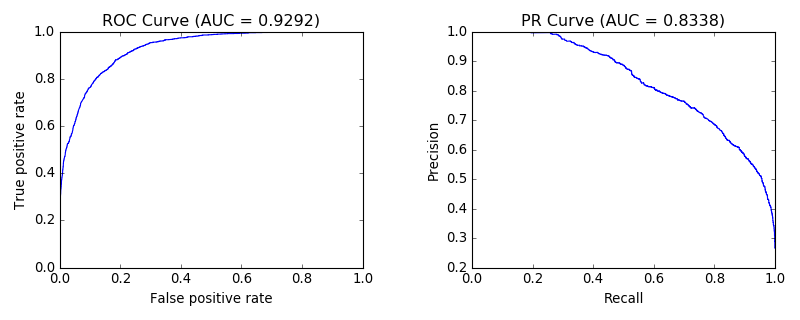

In [8]:
test_df, test_labels = load_data(test_file, label_col, feature_cols=feat.in_feature_names)
predictions = model.bulk_predict(test_df)

%matplotlib notebook
plot_roc_pr(test_labels, predictions);

We can also draw the confusion matrix to see the precision and recall for different thresholds.

In [9]:
confusion_matrix(test_labels, predictions)

                 PREDICTED            Recall
         ======F=============T======
         |            |            |
         F      5364  |       340  |  N: 94.04%
         |            |            |
LABELED  |-------------------------|
         |            |            |
         T       641  |      1216  |  P: 65.48%
         |            |            |
Precision   N: 89.33%     P: 78.15%


## Analyze features importance

In [10]:
fscores = model.get_fscores()
fscores.head(20)

Age_bin                              1953
Hours per week_bin                   1326
Capital Gain_bin                      579
Capital Loss_bin                      530
Years in Education_bin                513
Workclass=Private                     239
Occupation=Exec-managerial            236
Occupation=Prof-specialty             193
Sex=Male                              190
Workclass=Self-emp-not-inc            180
Education=HS-grad                     133
Education=Some-college                132
Occupation=Sales                      129
Relationship Status=Wife              123
Relationship Status=Not-in-family     121
Education=Bachelors                   119
Occupation=Craft-repair               118
Workclass=Local-gov                   110
Race=White                            108
Native Country=United-States          101
dtype: int64

## Model diagnostics

Here, we print out the top mismatches, i.e. the prediction is far from the label, for further review.

In [11]:
diagnostics = diagnose(model, test_df, test_labels, cols=fscores.index[0:10], predictions=predictions)
diagnostics.head(10)

,Labeled,Predicted Probability,Age Bin,Hours Per Week Bin,Capital Gain Bin,Capital Loss Bin,Years In Education Bin,Workclass=Private,Occupation=Exec-Managerial,Occupation=Prof-Specialty,Sex=Male,Workclass=Self-Emp-Not-Inc
7214,1,0.0014,4,7,0,0,3,0,0,0,1,0
149,1,0.0039,13,7,0,0,4,1,0,0,1,0
1492,1,0.007,8,7,0,0,13,1,0,0,0,0
4919,1,0.0089,5,7,0,0,10,1,0,0,1,0
5227,1,0.01,26,2,0,0,10,1,0,0,0,0
5306,1,0.011,17,7,0,0,9,1,0,0,1,0
1027,1,0.013,13,7,0,0,9,1,0,0,1,0
6512,1,0.013,9,14,0,0,9,1,0,0,0,0
1681,1,0.013,31,3,0,0,9,0,0,0,0,0
4618,1,0.014,23,7,0,0,9,1,0,0,0,0


## Model Saving and Loading
### Save model
Despite having superior performance, this model is actually smaller.

In [12]:
model_file = 'model.bin'
model.save(model_file)

from os import path
print('Model size: {0} KB'.format(path.getsize(model_file) >> 10))

Model size: 664 KB


### Load model

In [13]:
model = load(model_file)

### Scoring 
To score, just call `model.predict(features)` on raw features.